## 병렬 처리를 통한 효율 개선
- 아주 specific한 에이전트를 개발하는 경우 유리합니다 
- 답변을 생성할 때 다양한 정보가 필요하다면 병렬 처리를 통해 시간을 절약할 수 있습니다

### 부동산 과세표준 계산
1. 과제 표준 + 공제액 + 공정시장 가액 비율 계산 방법 알아내기 
2. 위의 3가지 정보를 통해 과세 표준 계산하기
3. 최종 answer가 되는 세율 계산 

In [19]:
from dotenv import load_dotenv

load_dotenv()

True

In [20]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [21]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 100,
    separators=['\n\n', '\n']
)

loader = TextLoader("../documents/real_estate_tax.txt")
document_list = loader.load_and_split(text_splitter)

In [22]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = Chroma.from_documents(
    documents=document_list, #위에서 전처리된 txt 데이터 
    embedding=embeddings,
    collection_name = 'real_estate_tax_collection',
    persist_directory = '../real_estate_tax_collection' #로컬에 영구 저장 버전 
)

In [23]:
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [45]:
from langchain_openai import ChatOpenAI
from langsmith import Client

#llm = ChatOpenAI(model='gpt-4o')
llm = ChatOpenAI(model='gpt-4o-mini')

client = Client()
rag_prompt = client.pull_prompt("rlm/rag-prompt")


In [25]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str # 사용자 질문
    answer: str # 질문에 대한 세율
    tax_base_equation: str # 과세표준 계산 수식 
    tax_deduction: str # 공제액 
    market_ratio: str # 공정시장가액비율
    tax_base: str # 과세표준 계산

In [26]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# 과세표준 계산 수식 (tax_base_equation)
def get_tax_base_equation(state: AgentState) -> AgentState:
    # 과세표준을 계산하는 방법을 묻는 질문을 정의합니다.
    tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'

    # 1. 과세표준 계산을 위한 Document Retriever RAG 체인 
    tax_base_retrieval_chain = (
        {'context': retriever, 'question': RunnablePassthrough()} 
        | rag_prompt 
        | llm 
        | StrOutputParser()
    )

    # 2. 과세표준 계산 정보를 수식 형태로 변환하기 위한 체인 
    tax_base_equation_prompt = ChatPromptTemplate.from_messages([
        ('system', '너는 과세표준을 계산 방법을 수식으로 변환하는 전문가야. 부연설명 없이 수식만 리턴해줘.'),
        ('human', "아래의 정보를 수식으로 변환해줘:\n\n[정보]\n{tax_base_equation_information}")
    ])

    tax_base_equation_chain = (
        {'tax_base_equation_information': RunnablePassthrough()}
        | tax_base_equation_prompt
        | llm
        | StrOutputParser()
    )

    tax_base_chain = {'tax_base_equation_information' : tax_base_retrieval_chain} | tax_base_equation_chain

    # tax_base_chain을 사용하여 질문을 실행하고 결과를 얻습니다.
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    
    # state에서 'tax_base_equation' 키에 대한 값을 반환합니다.
    return {'tax_base_equation': tax_base_equation}

In [27]:
# 공재금액 (tax_deduction)
def get_tax_deduction(state: AgentState) -> AgentState:
    # 공제금액을 묻는 질문을 정의합니다.
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요'

    tax_deduction_chain = (
        {'context': retriever, 'question': RunnablePassthrough()} 
        | rag_prompt 
        | llm 
        | StrOutputParser()
    )

    # tax_deduction_chain을 사용하여 질문을 실행하고 결과를 얻습니다.
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    
    # state에서 'tax_deduction' 키에 대한 값을 반환합니다.
    return {'tax_deduction': tax_deduction}

In [28]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

In [40]:
from datetime import date

# 공정시장 가액비율 (market_ratio)
def get_market_ratio(state: AgentState) -> AgentState:

    # 쿼리를 변수로 정의 (Node 내부에서만 사용)
    market_ratio_question = "오늘 날짜 기준 주택 공정시장가액비율(%) 수치를 정확히 추출해줘."

    # 공정시장 가액비율은 정보의 최신성이 중요하므로 웹 검색을 통해 정보 가져오기 
    context = tavily_search_tool.invoke(market_ratio_question)
    
    tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "너는 웹 검색 결과에서 필요한 수치만 뽑아내는 데이터 추출기야. "
            "다른 설명은 다 생략하고 오직 수치(예: 60%)만 답변해줘."
        ),
        (
            "human",
            f"오늘 날짜: {date.today()}\n\n"
            "웹 검색 결과: {context}\n\n"
            "추출할 정보: {query}"
        )
    ])
  
    tax_market_ratio_chain = tax_market_ratio_prompt | llm | StrOutputParser()
    
    market_ratio = tax_market_ratio_chain.invoke({'context': context, 'query': market_ratio_question})
    
    # state에서 'market_ratio' 키에 대한 값을 반환합니다.
    return {'market_ratio': market_ratio}

In [30]:
# 과세표준 계산 (tax_base)
def calculate_tax_base(state: AgentState) -> AgentState:
    # state에서 필요한 정보를 추출합니다.
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    
    tax_base_system_prompt = """ 
    당신은 부동산 과세표준 계산 전문가입니다. 
    주어진 공식 및 정보를 기반으로 사용자가 제공한 주택 공시가격 정보에 대한 과세 표준을 계산해주세요.
    - 과세표준 계산 공식: {tax_base_equation}
    - 공제금액: {tax_deduction}
    - 공정시장가액비율: {market_ratio}
    """
    
    tax_base_calculation_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', tax_base_system_prompt),
            ('human', '사용자 주택 공시가격 정보: {query}')
        ]
    )

    # tax_base_calculation_chain을 구성하여 과세표준을 계산합니다.
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_base_calculation_chain을 사용하여 과세표준을 계산합니다.
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })

    # state에서 'tax_base' 키에 대한 값을 반환합니다.
    return {'tax_base': tax_base}

In [ ]:
# 5. 최종 세율 계신 (answer)

def calculate_tax_rate(state: AgentState):
    # state에서 필요한 정보를 추출합니다.
    query = state['query']
    tax_base = state['tax_base']
    
    # retriever를 사용하여 쿼리를 실행하고 컨텍스트를 얻습니다.
    context = retriever.invoke(query)

    tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
        (
            'system', 
            '''당신은 종합부동산세 계산 전문가입니다. 
            아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요.'''
        ),
        (
            'human', 
            '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요.
            - 과세표준: {tax_base}
            - 주택 수:{query}''')
    ])

    # tax_rate_chain을 구성하여 세율을 계산합니다.
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_rate_chain을 사용하여 세율을 계산합니다.
    tax_rate = tax_rate_chain.invoke({
        'context': context, 
        'tax_base': tax_base, 
        'query': query
    })

    # state에서 'answer' 키에 대한 값을 반환합니다.
    return {'answer': tax_rate}

In [41]:

graph_builder = StateGraph(AgentState)

graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [42]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [43]:
graph = graph_builder.compile()

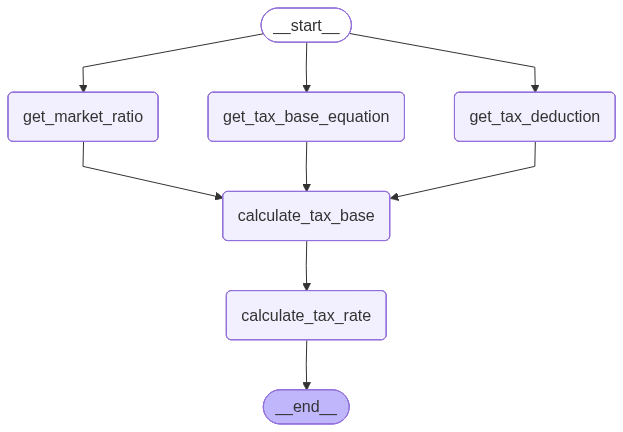

In [35]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'
initial_state = {'query': query}
result = graph.invoke(initial_state)

{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '사용자가 보유하고 있는 주택의 수가 3채이므로 종합부동산세의 세율을 3주택 이상 소유하는 경우의 세율에 따라 계산하겠습니다.\n\n### 과세표준 계산:\n- 주택 공시가격 합산: \n  - 5억 + 10억 + 20억 = 35억\n\n- 공제금액: \n  - 3주택 이상 소유하므로 9억원\n\n- 과세표준: \n  - 과세표준 = (합산 공시가격 - 공제금액)\n  - 과세표준 = (35억 - 9억) = 26억\n\n### 종합부동산세 계산:\n1. **26억 원 초과 25억 원 이하 부분의 세액**:\n   - 25억 원 초과 부분: 1억 원\n   - 세액: 35,600,000 원 + (1억 원 × 1천분의 30) = 35,600,000 원 + 300,000 원 = 35,900,000 원\n\n2. **요약하여 종합부동산세**: \n   - 종합부동산세 = 35,900,000 원\n\n따라서, 사용자는 **3,590만 원**을 종합부동산세로 납부해야 합니다.',
 'tax_base_equation': '과세표준 = (합산 공시가격 - 공제금액) × 공정시장가액비율',
 'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자는 12억원, 법인 또는 법인으로 보는 단체는 6억원, 그 외의 경우는 9억원입니다. 이러한 공제는 주택의 공시가격에서 차감된 후 세액이 계산됩니다. 또한, 연령에 따라 추가적인 공제율이 적용될 수 있습니다.',
 'market_ratio': '60%',
 'tax_base': '주어진 정보에 따라 과세표준을 계산해보겠습니다.\n\n1. 주택 공시가격 정보를 합산합니다.\n   - 5억 + 10억 + 20억 = 35억\n\n2. 1세대 1주택자 경우 공제금액은 12억원입니다. 그러나 사용자는 주택을 3채 보유하고 있으므로 그 외의 경우로 간주되어 공제금액은 